***
# Imports
### <span style="color: red;">NB. Used Python 3.10.6 kernel</span>
### <span style="color: red;">run command in root of this folder:</span> make install_requirements 

In [24]:
import os.path
import time
            # data sourcing:
import csv
            # databases:
import sqlite3
            # useful other
from collections import defaultdict
            # data toolkit:
import numpy as np
import pandas as pd
            # plotting
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
            # sklearn techniques
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsOneClassifier
from sklearn.utils import shuffle
            # sklearn models
from sklearn.linear_model import LinearRegression, LogisticRegression

***
# Sourcing data and handling it

In [25]:
# check raw data archive path extant:
atp_data_path = os.path.join('..','raw_data','archive')
assert os.path.exists(atp_data_path)

In [26]:
# download to the raw_data folder from the following url
dataset_url = 'https://www.kaggle.com/datasets/ehallmar/a-large-tennis-dataset-for-atp-and-itf-betting?select=all_tournaments.csv'

# unzip archive

# confirm .csv files x 7 are there:
assert os.path.isfile('../raw_data/archive/all_matches.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/all_players.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/all_tournaments.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/betting_moneyline.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/betting_spreads.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/betting_totals.csv'), 'all_matches.csv not found. download from url above'
assert os.path.isfile('../raw_data/archive/countries.csv'), 'all_matches.csv not found. download from url above'


In [27]:
# check iniital data file expected are extant:
matches_data_path_full = os.path.join(atp_data_path, 'all_matches.csv')
assert os.path.exists(matches_data_path_full)

In [28]:

# needs care here, too big for memory 
matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None)
matches_df_1st_50k.tail()

/tmp/ipykernel_33478/1814627133.py:2: DtypeWarning: Columns (8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  matches_df_1st_50k = pd.read_csv(matches_data_path_full, nrows=50_000, index_col=None)


,start_date,end_date,location,court_surface,prize_money,currency,year,player_id,player_name,opponent_id,...,total_points,duration,player_victory,retirement,seed,won_first_set,doubles,masters,round_num,nation
49995,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen,NaN,pablo-figueroa,...,NaN,NaN,f,f,2.0,f,f,25,3,DEN
49996,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen_rasmus-norby,NaN,andrea-arnaboldi_nicolas-tourte,...,NaN,NaN,t,f,NaN,t,t,25,7,DEN
49997,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen_rasmus-norby,NaN,andreas-siljestrom_oskar-pallin,...,NaN,NaN,t,f,NaN,t,t,25,6,DEN
49998,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen_rasmus-norby,NaN,antti-tuomi_niklas-bucht,...,NaN,NaN,t,f,NaN,t,t,25,4,DEN
49999,2004-07-05,2004-07-11,DEN,Clay,NaN,NaN,2004,frederik-nielsen_rasmus-norby,NaN,jacob-melskens_tore-deleuran-skjold,...,NaN,NaN,t,f,NaN,t,t,25,5,DEN


In [29]:
matches_data_path = os.path.join(atp_data_path, 'all_matches_1st50k.csv')

In [30]:
# save a sample so we can establish working without using the whole dataset:
save_csv_back_out = 0
if save_csv_back_out:
    matches_df_1st_50k.to_csv(matches_data_path)

In [31]:
# confirm file is there:
assert os.path.exists(matches_data_path)
# if you get an error here, rerun the cell above with 'save_csv_back_out = 1'

In [32]:
# KEEP FOR LATER
# not using until we work on the data and save it out in stages:

# matches_data_path_latest = os.path.join(atp_data_path, 'all_matches_1st50k_latest.csv')
# assert os.path.exists(matches_data_path_latest)

***
# First EDA (Exploratory Data Analysis)

In [33]:
# this gets stuck, hence: 'run_difficult_cell'
run_difficult_cell = 0
if run_difficult_cell:
    matches_data_latest = pd.read_csv(matches_data_path_full, index_col=0)

### Notes:
- It became clear above that loading the 4.3m rows into pandas cannot
be handled by this machine
- Could use the cloud - and will try later, but initially let's try with
these limited resources, it's good practice.

In [34]:
# revert to using Dataframe above, suffices for now
matches_df_1st_50k.info() 
# 50_000 rows is <21mb in memory

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 54 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   start_date                            50000 non-null  object 
 1   end_date                              48967 non-null  object 
 2   location                              50000 non-null  object 
 3   court_surface                         50000 non-null  object 
 4   prize_money                           15537 non-null  float64
 5   currency                              15537 non-null  object 
 6   year                                  50000 non-null  int64  
 7   player_id                             50000 non-null  object 
 8   player_name                           10298 non-null  object 
 9   opponent_id                           50000 non-null  object 
 10  opponent_name                         10298 non-null  object 
 11  tournament     

In [35]:
# first look at columns 
matches_df_1st_50k.columns

Index(['start_date', 'end_date', 'location', 'court_surface', 'prize_money',
       'currency', 'year', 'player_id', 'player_name', 'opponent_id',
       'opponent_name', 'tournament', 'round', 'num_sets', 'sets_won',
       'games_won', 'games_against', 'tiebreaks_won', 'tiebreaks_total',
       'serve_rating', 'aces', 'double_faults', 'first_serve_made',
       'first_serve_attempted', 'first_serve_points_made',
       'first_serve_points_attempted', 'second_serve_points_made',
       'second_serve_points_attempted', 'break_points_saved',
       'break_points_against', 'service_games_won', 'return_rating',
       'first_serve_return_points_made', 'first_serve_return_points_attempted',
       'second_serve_return_points_made',
       'second_serve_return_points_attempted', 'break_points_made',
       'break_points_attempted', 'return_games_played', 'service_points_won',
       'service_points_attempted', 'return_points_won',
       'return_points_attempted', 'total_points_won', 'total

In [36]:
# there are a bunch of columns we can avoid using, certainly initially
# looking at the datatypes, there is probably a lot of room for memory reduction

In [37]:
# NOTE from Pandas: columns 5, 8, 10, 45, 48 have mixed datatypes:
mixed_datatypes = ['currency', 'player_name', 'opponent_name', 'duration', 'seed']
# let's see:
print(matches_df_1st_50k.iloc[:,[5, 8, 10, 45, 48]].head())

  currency   player_name  opponent_name  duration seed
0        €      A. Partl      A. Martin  01:02:00  NaN
1        €      A. Partl     J. Kovalik  02:43:00  NaN
2        €    A. Velotti      D. Hrbaty  01:17:00  NaN
3        €           NaN            NaN       NaN  NaN
4        €  A. Giannessi  H. Heliovaara  02:32:00    1


In [38]:
matches_df_1st_50k.value_counts()

start_date  end_date    location                                              court_surface  prize_money  currency  year  player_id              player_name       opponent_id             opponent_name    tournament               round                 num_sets  sets_won  games_won  games_against  tiebreaks_won  tiebreaks_total  serve_rating  aces  double_faults  first_serve_made  first_serve_attempted  first_serve_points_made  first_serve_points_attempted  second_serve_points_made  second_serve_points_attempted  break_points_saved  break_points_against  service_games_won  return_rating  first_serve_return_points_made  first_serve_return_points_attempted  second_serve_return_points_made  second_serve_return_points_attempted  break_points_made  break_points_attempted  return_games_played  service_points_won  service_points_attempted  return_points_won  return_points_attempted  total_points_won  total_points  duration  player_victory  retirement  seed  won_first_set  doubles  masters  roun

In [39]:
matches_df_1st_50k.describe()

,prize_money,year,num_sets,sets_won,games_won,games_against,tiebreaks_won,tiebreaks_total,serve_rating,aces,...,break_points_attempted,return_games_played,service_points_won,service_points_attempted,return_points_won,return_points_attempted,total_points_won,total_points,masters,round_num
count,1.553700e+04,50000.000000,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.000000,10298.000000,10298.000000,...,10298.000000,10298.000000,10298.000000,10298.000000,10298.000000,10298.000000,10298.000000,10298.000000,50000.000000,50000.000000
mean,3.796909e+06,2006.594400,2.313920,1.15450,10.854560,10.85390,0.128100,0.256260,261.542435,5.526122,...,6.470188,11.608662,46.852301,74.486696,27.634007,74.481841,74.486308,148.968538,274.302000,2.649080
std,6.579064e+06,12.810598,0.627138,0.95365,5.432237,5.43239,0.359128,0.506395,40.758831,4.816104,...,4.155581,3.547386,16.840465,25.307795,11.281841,25.308832,25.697776,48.842251,542.212359,1.979033
min,1.060000e+04,1950.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-2.000000
25%,1.500000e+05,2000.000000,2.000000,0.00000,7.000000,7.00000,0.000000,0.000000,236.000000,2.000000,...,3.000000,9.000000,35.000000,56.000000,20.000000,56.000000,57.000000,112.000000,25.000000,1.000000
50%,6.427500e+05,2010.000000,2.000000,1.00000,12.000000,12.00000,0.000000,0.000000,265.000000,4.000000,...,6.000000,11.000000,44.000000,70.000000,27.000000,70.000000,71.000000,140.000000,25.000000,3.000000
75%,3.826655e+06,2015.000000,3.000000,2.00000,13.000000,13.00000,0.000000,0.000000,291.000000,8.000000,...,9.000000,14.000000,57.000000,91.000000,34.000000,91.000000,91.000000,181.000000,250.000000,4.000000
max,2.509600e+07,2018.000000,5.000000,4.00000,126.000000,126.00000,3.000000,3.000000,376.000000,53.000000,...,30.000000,34.000000,154.000000,225.000000,91.000000,225.000000,215.000000,420.000000,2000.000000,7.000000


In [40]:
print(f'player_name: {matches_df_1st_50k.player_name.count()} and player_id: {matches_df_1st_50k.player_id.count()}')
print(f'player_name: {matches_df_1st_50k.opponent_name.count()} and player_id: {matches_df_1st_50k.opponent_id.count()}')
# seems low ~20% of data

player_name: 10298 and player_id: 50000
player_name: 10298 and player_id: 50000


In [41]:
pd.to_datetime(matches_df_1st_50k.end_date)
display(matches_df_1st_50k.end_date.head())
pd.to_datetime(matches_df_1st_50k.start_date)
display(matches_df_1st_50k.start_date.head())
# using a simple to_datetime conversion works, 

0    2012-06-17
1    2012-06-17
2    2012-06-17
3    2012-06-17
4    2012-06-17
Name: end_date, dtype: object

0    2012-06-11
1    2012-06-11
2    2012-06-11
3    2012-06-11
4    2012-06-11
Name: start_date, dtype: object

In [42]:
print(f'oldest date: {matches_df_1st_50k.start_date.min()} and most recent: {matches_df_1st_50k.start_date.max()}')
# Interesting to see the 1950's represented

oldest date: 1950-08-25 and most recent: 2018-08-13


In [43]:
# Let's see the count per year or decade

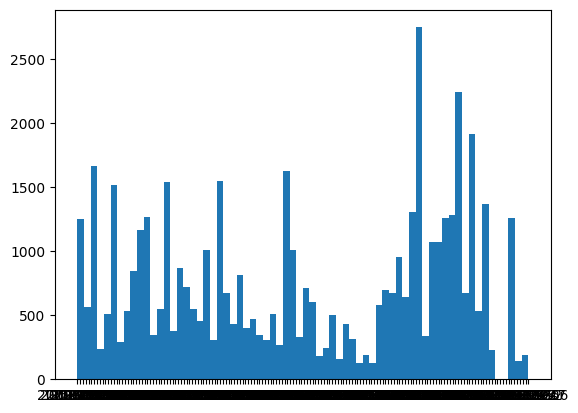

In [44]:
plt.hist(matches_df_1st_50k.start_date,bins=68); # attempting by year
# Again, this is an interesting picture.
# Prompts question about number of tennis events per year, and similar
# And there seems to be a gap in the data around 2015 or something

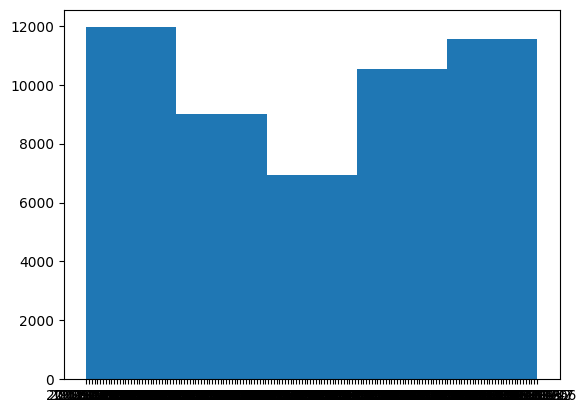

In [45]:
plt.hist(matches_df_1st_50k.start_date,bins=5); # attempting by decade

# for both by year and by decade, it's clear that the whole dataset will be 
# needed - no idea yet how the whole dataset is distributed by date 

*** 
# Start to get a little organised per column
### Aim to later use these dicts to treat the data differently

In [88]:
# keep a simple dict of columns to see how full they are
# could use a simple .count() but going to run across mutiple chunks, and only want to see specific columns
check_completeness = {'start_date': 0, 'end_date': 0, 'player_name': 0, 
                      'duration': 0
                      }

check_key_distinguishing_columns = {'doubles': 0, 'masters': 0, 'nation': 0
                                    , 'seed': 0, 'prize_money': 0,}

check_numerical_columns = {'prize_money': 0,'sets_won': 0,  'sets_won': 0,'games_won': 0,  
                           'games_against': 0, 'tiebreaks_won': 0,  'tiebreaks_total': 0,
                      'serve_rating': 0, 'aces': 0, 
                      'double_faults': 0, 'first_serve_made': 0, 
                      'first_serve_attempted': 0, 'first_serve_points_made': 0,  
                      'first_serve_points_attempted': 0, 'second_serve_points_made': 0, 
                      'second_serve_points_attempted': 0, 'break_points_saved': 0, 
                      'break_points_against': 0, 'service_games_won': 0, 
                      'return_rating': 0, 'first_serve_return_points_made': 0, 
                      'first_serve_return_points_attempted': 0, 'second_serve_return_points_made': 0, 
                      'second_serve_return_points_attempted': 0, 'break_points_made': 0, 
                      'break_points_attempted': 0, 'return_games_played': 0, 
                      'service_points_won': 0, 'service_points_attempted': 0, 
                      'return_points_won': 0, 'return_points_attempted': 0, 
                      'total_points_won': 0, 'total_points': 0, 
                      'duration': 0, 
                      # distinguishing column:
                      'round_num': 0
                      }

check_mixed_columns = {'seed': 0, 'currency': 0, 'player_name': 0, 'opponent_name': 0, 'duration': 0}

check_boolean_columns = {'player_victory': 0, 'retirement': 0, 'won_first_set': 0, 
                         }
# # list(check_completeness.keys())
# for i in check_completeness:
#     print(i)

In [84]:
# in the first 50_000 rows, column counts for these columns gives: 
for i in check_completeness.keys():
    count = matches_df_1st_50k[i].count()
    check_completeness[i] += count

In [90]:
print(check_completeness)

{'start_date': 0, 'end_date': 0, 'player_name': 0, 'duration': 0}


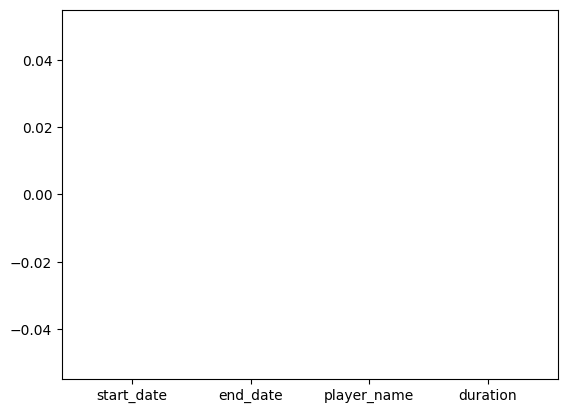

In [89]:
D = check_completeness
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

In [87]:
for i in check_boolean_columns:
    count = matches_df_1st_50k[i].count()
    check_boolean_columns[i] += count

In [51]:
print(check_boolean_columns)

{'player_victory': 50000, 'retirement': 50000, 'won_first_set': 49301}


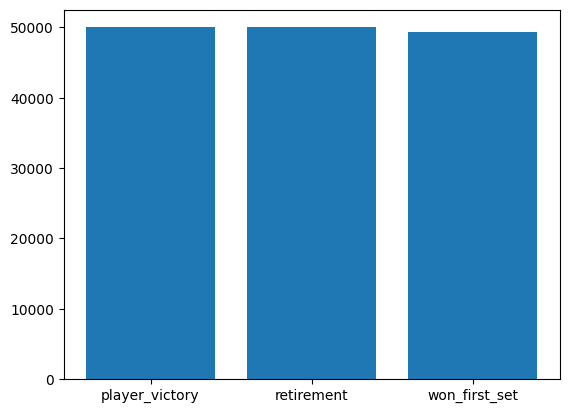

In [52]:
D = check_boolean_columns
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

In [53]:
for i in check_mixed_columns:
    count = matches_df_1st_50k[i].count()
    check_mixed_columns[i] += count

In [54]:
print(check_mixed_columns)

{'seed': 17926, 'currency': 15537, 'player_name': 10298, 'opponent_name': 10298, 'duration': 10298}


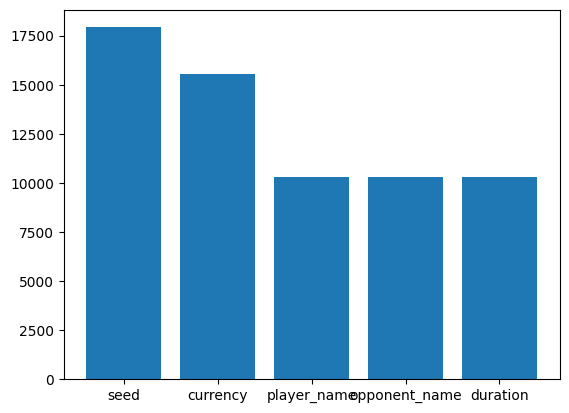

In [55]:
D = check_mixed_columns
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

In [56]:
for i in check_numerical_columns:
    count = matches_df_1st_50k[i].count()
    check_numerical_columns[i] += count

In [57]:
display(check_numerical_columns)
print(min(check_numerical_columns))
print(max(check_numerical_columns))

{'prize_money': 15537,
 'sets_won': 50000,
 'games_won': 50000,
 'games_against': 50000,
 'tiebreaks_won': 50000,
 'tiebreaks_total': 50000,
 'serve_rating': 10298,
 'aces': 10298,
 'double_faults': 10298,
 'first_serve_made': 10298,
 'first_serve_attempted': 10298,
 'first_serve_points_made': 10298,
 'first_serve_points_attempted': 10298,
 'second_serve_points_made': 10298,
 'second_serve_points_attempted': 10298,
 'break_points_saved': 10298,
 'break_points_against': 10298,
 'service_games_won': 10298,
 'return_rating': 10298,
 'first_serve_return_points_made': 10298,
 'first_serve_return_points_attempted': 10298,
 'second_serve_return_points_made': 10298,
 'second_serve_return_points_attempted': 10298,
 'break_points_made': 10298,
 'break_points_attempted': 10298,
 'return_games_played': 10298,
 'service_points_won': 10298,
 'service_points_attempted': 10298,
 'return_points_won': 10298,
 'return_points_attempted': 10298,
 'total_points_won': 10298,
 'total_points': 10298,
 'duratio

aces
total_points_won


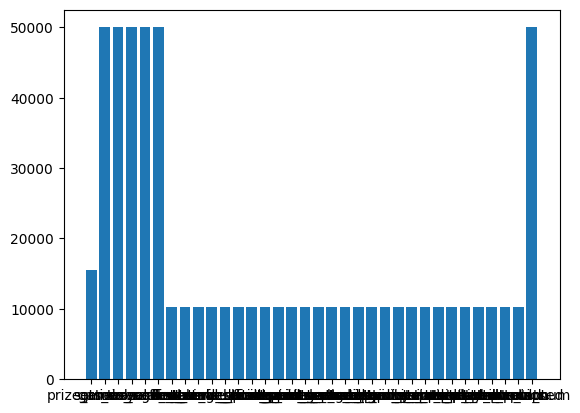

In [58]:
# quick chart to see:
D = check_numerical_columns
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

In [59]:
for i in check_key_distinguishing_columns:
    count = matches_df_1st_50k[i].count()
    check_key_distinguishing_columns[i] += count

In [60]:
print(check_key_distinguishing_columns)

{'doubles': 50000, 'masters': 50000, 'nation': 50000, 'seed': 17926, 'prize_money': 15537}


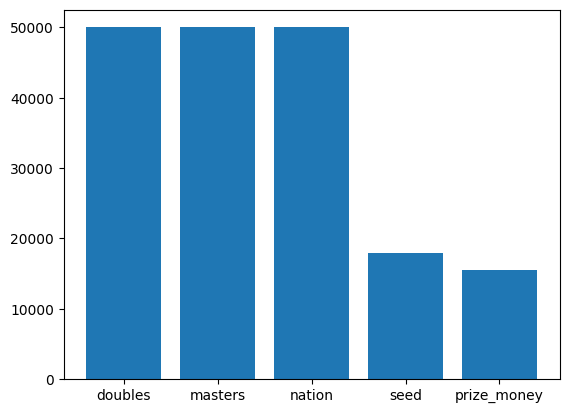

In [61]:
D = check_key_distinguishing_columns
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

***
# Approaches and techniques trialling (for subsequent application in a pipeline)

### Dropping columns
A: Names

In [62]:
# given the repetition of player_ and opponent_ name and id we can drop 2 columns
# 2 checks are needed:
#       1: That the full data repeats the pattern above
#       2: That the ids all match with the all_players csv 
columns_to_drop = ['player_name', 'opponent_name']

In [63]:
# Dealing with the mixed datatypes
print(matches_df_1st_50k.iloc[:,[5, 8, 10, 45, 48]].head())

  currency   player_name  opponent_name  duration seed
0        €      A. Partl      A. Martin  01:02:00  NaN
1        €      A. Partl     J. Kovalik  02:43:00  NaN
2        €    A. Velotti      D. Hrbaty  01:17:00  NaN
3        €           NaN            NaN       NaN  NaN
4        €  A. Giannessi  H. Heliovaara  02:32:00    1


In [64]:
matches_df_1st_50k.iloc[:,[5, 8, 10, 45, 48]].isna().sum()
# on the basis that these numbers are high percentages, all over 60%, some care
# is needed. player_name, opponent_name and duration look to be nearly 80% NA
# 
# will need to confirm this through the rest of the data

currency         34463
player_name      39702
opponent_name    39702
duration         39702
seed             32074
dtype: int64

***
# 1st Attempt to go through the FULL dataset

In [91]:
def check_through_count(dataframe, dict_to_check):
    for i in dict_to_check.keys():
        count = dataframe[i].count()
        dict_to_check[i] += count
    return dict_to_check

In [92]:
# to go through all the sample data set

start = time.time()

ave_bytes = 0
count = 0
total_bytes = 0

header = True

# This enumerate function selects repeated chunks of XXX rows of data 
for index, chunk in enumerate(pd.read_csv(matches_data_path_full
                                            , chunksize= 100_000
                                            # usecols = list(check_completeness.keys()), # can be index based (but not -1): [0, 7]
                                            , parse_dates=True
                                            ),
                              start=1):
    this_bytes = chunk.memory_usage().sum()
    ave_bytes += this_bytes
    total_bytes = total_bytes + this_bytes
    # This inner loop iterates through the rate keys only.Then it does 
    # vectorised selections on the dataframe to select count of each rate key.
    
    # count data points and accumulate in the 5 dicts
    check_completeness = check_through_count(chunk, check_completeness)
    check_key_distinguishing_columns = check_through_count(chunk, check_key_distinguishing_columns)
    check_numerical_columns = check_through_count(chunk, check_numerical_columns)
    check_mixed_columns = check_through_count(chunk, check_mixed_columns)
    check_boolean_columns = check_through_count(chunk, check_boolean_columns)
    
        # make changes
    
    #     
    # chunk.to_csv(matches_data_path_latest,
    #              header=header, 
    #              mode='a',
    #              # cols=[['','']]
    #              )
    # header = False # so only first row gets a header

print(f"Total number of chunks: {index}")
print(f"Total memory, MB: {round(total_bytes/100_000,0):,}")
ave_bytes = ave_bytes / index
print(f"Average MB per loop: {round(ave_bytes/100_000,0):,}")
print(check_completeness)

print(round(time.time() - start,2), ' seconds')

# Total number of chunks: 43 ______________________ of 100_000 rows
# Total memory, MB: 18,558.0
# Average MB per loop: 432.0
# {'start_date': 4395827, 'end_date': 4295393, 'player_name': 375001, 'duration': 372823}
# 72.15  seconds

/tmp/ipykernel_33478/3913598919.py:12: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  for index, chunk in enumerate(pd.read_csv(matches_data_path_full
/tmp/ipykernel_33478/3913598919.py:12: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  for index, chunk in enumerate(pd.read_csv(matches_data_path_full
/tmp/ipykernel_33478/3913598919.py:12: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  for index, chunk in enumerate(pd.read_csv(matches_data_path_full
/tmp/ipykernel_33478/3913598919.py:12: DtypeWarning: Columns (8,10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  for index, chunk in enumerate(pd.read_csv(matches_data_path_full
/tmp/ipykernel_33478/3913598919.py:12: DtypeWarning: Columns (5,8,10,45,48) have mixed types. Specify dtype option on import or set low_memory=False.
  

Total number of chunks: 43
Total memory, MB: 18,558.0
Average MB per loop: 432.0
{'start_date': 4295827, 'end_date': 4197459, 'player_name': 354405, 'duration': 352227}
80.45  seconds


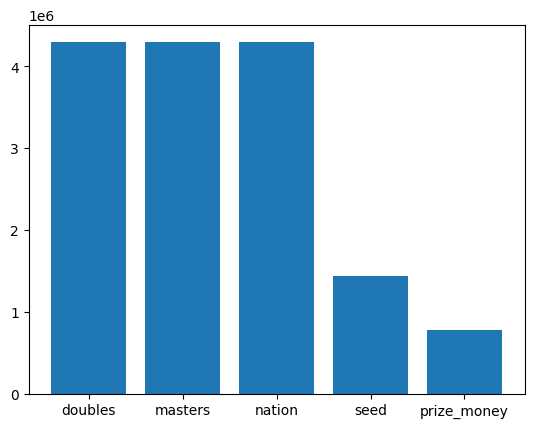

In [97]:
# check_completeness check_boolean_columns check_mixed_columns 
# check_numerical_columns check_key_distinguishing_columns
D = check_key_distinguishing_columns
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()));

In [66]:
types = defaultdict(str, aces=int, currency=float)
# df = pd.read_csv("/path/to/file.csv", dtype=types, keep_default_na=False)
col_dtype_changes = {'location': str, 'aces': float} # 'start_date': np.datetime64, 'end_date': np.datetime64, 

In [67]:
# now to adjust the datatypes as each chunk is loaded:
# BUT
# dtype conversions fail as empty cells etc - skip cell for now
skip_cell = 1

if not skip_cell: 
    start = time.time()
    ave_bytes = 0
    count = 0
    total_bytes = 0
    header = True
    # This enumerate function selects repeated chunks of 1,000,000 rows of data 
    for index, chunk in enumerate(pd.read_csv(matches_data_path_full 
                                                , chunksize= 100_000
                                                , usecols = ['aces'] # list(check_completeness.keys()), # can be index based (but not -1): [0, 7]
                                                , dtype=col_dtype_changes # types
                                                , parse_dates=True
                                                , keep_default_na=False),
                                start=1):
        this_bytes = chunk.memory_usage().sum()
        ave_bytes += this_bytes
        total_bytes = total_bytes + this_bytes
        # This inner loop iterates through the rate keys only.Then it does 
        # vectorised selections on the dataframe to select count of each rate key.
        for i in check_completeness:
            count = chunk[i].count()
            check_completeness[i] += count
            
        for i in check_boolean_columns:
            count = chunk[i].count()
            check_boolean_columns[i] += count

        # chunk.to_csv(matches_data_path_latest,
        #             header=header, 
        #             mode='a',
        #             # cols=[['','']]
        #             )
        header = False # so only first row gets a header

    print(f"Total number of chunks: {index}")
    print(f"Total memory, MB: {round(total_bytes/100_000,0):,}")
    ave_bytes = ave_bytes / index
    print(f"Average bytes per loop: {round(ave_bytes/100_000,0):,}")
    print(check_completeness)

    print(round(time.time() - start,2), ' seconds')

ValueError: could not convert string to float: ''

# See above, an attempt to convert data types on load fails
    This is because there are >1 datatypes in a single column, e.g. 'aces' which has at least: float, str

In [ ]:
# when done with data processing, save back to single file with mode="a" 
# header = True
# for chunk in chunks:

#     chunk.to_csv(os.path.join(folder, new_folder, "new_file_" + filename),
#         header=header, cols=[['TIME','STUFF']], mode='a')

#     header = False

In [ ]:
matches_column_names = matches_df.columns
matches_column_names

In [ ]:
matches_dtypes = matches_df.dtypes
matches_df_objects = matches_dtypes[matches_dtypes==object]
matches_df_objects = pd.DataFrame(matches_df_objects).reset_index()
matches_df_objects.rename(columns={'index': 'column_name', 0: 'dtype'}, inplace=True)
print(matches_df_objects.columns)
matches_df_objects

In [ ]:
matches_date_columns = matches_df_objects[:2]
matches_date_columns

In [ ]:
middle_cols = matches_df[matches_df.columns[12:20]]
middle_cols

In [ ]:
# ! pip install polars
# import polars as pl # this will not work on my machine

# !pip install polars-lts-cpu
import polars as pl

In [ ]:
# this crashes, too big 890mb
matches_csv_file = '../raw_data/archive/all_matches.csv'
# matches_df_polar = pl.read_csv()
# matches_df_polar = pl.read_csv_batched(matches_csv_file)
reader = pl.read_csv_batched(

    matches_csv_file,

    try_parse_dates=True,

)  

batches = reader.next_batches(5)  

for df in batches:  

    print(df)
    


In [ ]:
df.dtypes.head()

In [ ]:
len(df.columns)

*** 
***
# Pipeline
***
***

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipeline = Pipeline([])

In [ ]:
pipeline